Регрессия — это задача прогнозирования непрерывной числовой величины (например, цены, температуры, времени). В отличие от классификации, где выход — дискретный класс, регрессия предсказывает число.

Типы задач регрессии

1.Линейная регрессия

Прогнозирование одной целевой переменной на основе линейной зависимости от признаков.

Пример: предсказание цены дома по его площади, количеству комнат.

2.Множественная регрессия

Несколько входных признаков → одна целевая переменная.

Пример: прогноз температуры по влажности, давлению, скорости ветра.

3.Полиномиальная регрессия
Нелинейная зависимость (например, парабола y=ax2+bx+c)

4.Временные ряды

Прогнозирование значений на основе предыдущих точек (например, курс акций).

5.Регрессия с регулярлизацией

L1- (Lasso) и L2- (Ridge) регуляризация для борьбы с переобучением.

In [1]:
from sklearn.datasets import fetch_california_housing # Цены домов в Калифорнии
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import torch
import torch.nn as nn

In [2]:
# Загрузка данных
data = fetch_california_housing()
X, Y = data.data, data.target

print(f"Размерность данных: {X.shape}")
print(f"Пример признаков: {X[0]}")
print(f"Пример целевой переменной: {Y[0]}")
print(f"Названия признаков: {data.feature_names}")

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Конвертация в тензоры
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)


Размерность данных: (20640, 8)
Пример признаков: [   8.3252       41.            6.98412698    1.02380952  322.
    2.55555556   37.88       -122.23      ]
Пример целевой переменной: 4.526
Названия признаков: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)  # Один выход
    
    def forward(self, x):
        return self.linear(x)

In [4]:
class NNRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        self.dropout = nn.Dropout(0.2)
        return self.fc2(x)

In [5]:
model = NNRegression(X_train.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error для регрессии
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 100, Loss: 0.6781
Epoch 200, Loss: 0.5276
Epoch 300, Loss: 0.4449
Epoch 400, Loss: 0.4050
Epoch 500, Loss: 0.3818
Epoch 600, Loss: 0.3644
Epoch 700, Loss: 0.3508
Epoch 800, Loss: 0.3406
Epoch 900, Loss: 0.3303
Epoch 1000, Loss: 0.3234


In [6]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    y_pred  = model(X_test)
    test_loss = criterion(y_pred , y_test)
    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    
    # Вычисление метрик
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'\nMSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')

Test Loss (MSE): 0.3380

MSE: 0.3380
RMSE: 0.5813
R² Score: 0.7421


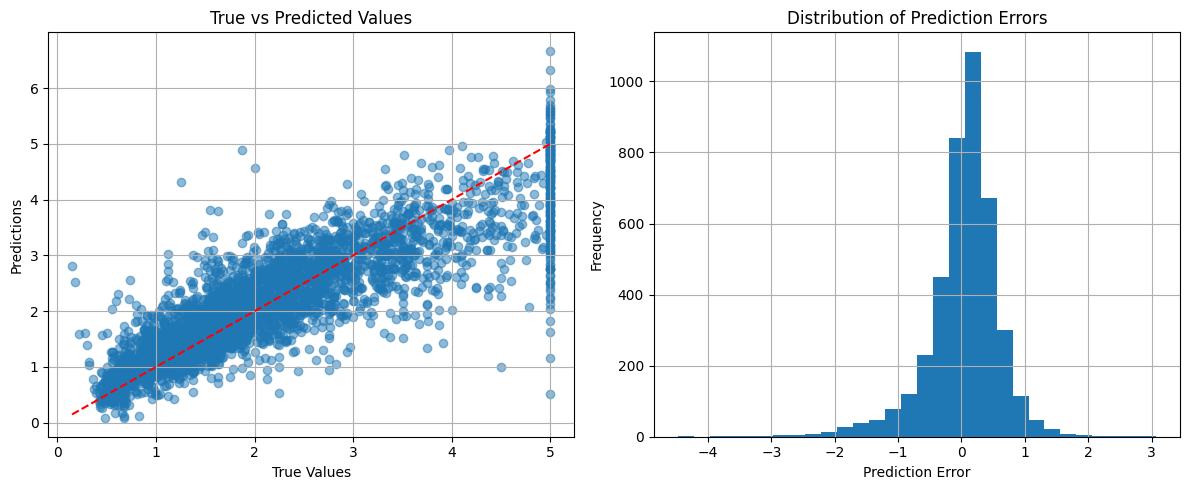

In [7]:
# Визуализация результатов
plt.figure(figsize=(12, 5))

# График истинных vs предсказанных значений
plt.subplot(1, 2, 1)
plt.scatter(y_test.numpy(), y_pred.numpy(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.grid(True)

# График распределения ошибок
plt.subplot(1, 2, 2)
errors = y_pred.numpy() - y_test.numpy()
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)

plt.tight_layout()
plt.show()